## SIE Lens Cross Section Estimator 
#### [Author: Manish Tamta]

Equation (A13) taken from https://arxiv.org/abs/1807.07062

Let us define,
$$ A \equiv \sqrt{\frac{q}{1-q^2}} $$

$$
f(\phi; y_1,y_2,q) = \Bigg[y_1 + A \, \operatorname{arcsinh}\!\left(\frac{\sqrt{1-q^2}}{q}\cos\phi\right)
\Bigg]\sin\phi
-
\Bigg[y_2 + A \, \arcsin\!\left(\sqrt{1-q^2}\sin\phi\right)\Bigg]\cos\phi= 0
$$

Acceptance condition (A14)
$$
\Bigg[y_1 + A \, \operatorname{arcsinh}\!\left(\frac{\sqrt{1-q^2}}{q}\cos\phi\right)\Bigg]\cos\phi
+
\Bigg[y_2 + A \, \arcsin\!\left(\sqrt{1-q^2}\sin\phi\right)\Bigg]\sin\phi > 0
$$

## Cross Section Estimator

Image multiplicity
$$N_{\mathrm{img}}(y_1,y_2) = \#\left\{\phi_i \in [0,2\pi)|f(\phi_i)=0 \ \text{and (A14) holds}\right\}$$

Boolean masks
$$
\begin{aligned}
\mathcal{M}_4 &:= \{(y_1,y_2)\mid N_{\mathrm{img}}=4\}, \\
\mathcal{M}_2 &:= \{(y_1,y_2)\mid N_{\mathrm{img}}=2\}, \\
\mathcal{M}_{\mathrm{net}} &:= \{(y_1,y_2)\mid N_{\mathrm{img}}\ge 2\}.
\end{aligned}
$$

Derived masks (based on logic)
$$
\mathcal{M}_4^{(\mathrm{net})}
=
\mathcal{M}_{\mathrm{net}} \setminus \mathcal{M}_2
$$

$$
\mathcal{M}_2^{(\mathrm{net})}
=
\mathcal{M}_{\mathrm{net}} \setminus \mathcal{M}_4
$$

Double-image mask (custom logic)
$$
\mathcal{M}_2^{(\mathrm{final})}
=
\mathcal{M}_{\mathrm{net}}
\setminus
\left[
\left(\mathcal{M}_{\mathrm{net}} \setminus \mathcal{M}_4\right)
\cup
\mathcal{M}_2^{(\mathrm{net})}
\right]
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from matplotlib.patches import Patch

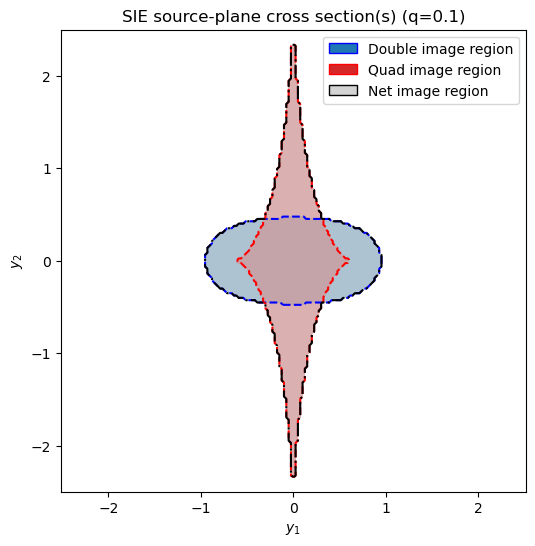

q = 0.1
2-image cross section = 1.4671
4-image cross section = 1.6793
Sum (2+4) cross section = 3.1464
Net cross section = 2.3611


In [ ]:
# ==================================================
# Eq. (A13)
# ==================================================
def f_A13(phi, y1, y2, q):
    A = np.sqrt(q / (1 - q**2))
    term1 = y1 + A * np.arcsinh(np.sqrt(1 - q**2)/q * np.cos(phi))
    term2 = y2 + A * np.arcsin(np.sqrt(1 - q**2) * np.sin(phi))
    return term1 * np.sin(phi) - term2 * np.cos(phi)

# ==================================================
# Acceptance condition (A14)
# ==================================================
def accept_A14(phi, y1, y2, q):
    A = np.sqrt(q / (1 - q**2))
    term1 = y1 + A * np.arcsinh(np.sqrt(1 - q**2)/q * np.cos(phi))
    term2 = y2 + A * np.arcsin(np.sqrt(1 - q**2) * np.sin(phi))
    return term1 * np.cos(phi) + term2 * np.sin(phi) > 0

# ==================================================
# Root finder
# ==================================================
def find_phi_roots(y1, y2, q, Nphi=1200):
    phis = np.linspace(0, 2*np.pi, Nphi)
    fvals = f_A13(phis, y1, y2, q)

    roots = []
    for i in range(len(phis)-1):
        if fvals[i] * fvals[i+1] < 0:
            try:
                root = brentq(f_A13, phis[i], phis[i+1], args=(y1, y2, q))
                roots.append(root)
            except ValueError:
                pass

    roots = np.unique(np.round(roots, 6))
    roots = [phi for phi in roots if accept_A14(phi, y1, y2, q)]
    return roots

# ==================================================
# Cross sections for a given q
# ==================================================
def cross_sections_for_q(q, Ny=200, ymax=2.5): #Ny = 200
    y1 = np.linspace(-ymax, ymax, Ny)
    y2 = np.linspace(-ymax, ymax, Ny)
    dy = y1[1] - y1[0]

    Y1, Y2 = np.meshgrid(y1, y2)
    Nimg = np.zeros((Ny, Ny), dtype=int)

    for i in range(Ny):
        for j in range(Ny):
            roots = find_phi_roots(Y1[i, j], Y2[i, j], q)
            Nimg[i, j] = len(roots)

    ## DISJOINT masks
    mask_4_ = (Nimg == 4)
    mask_2_ = (Nimg == 2)
    mask_net = (Nimg >= 2) ## net image region
    
    mask_4 = mask_net & (~mask_2_)   ## quad-only region
    mask_2__ = mask_net & (~mask_4_)
    mask_2 = mask_net & (~(mask_net & (~mask_4) + 1 * mask_2__)) ## double-only region
    
    ## cross section(s)
    sigma_4 = np.sum(mask_4) * dy**2
    sigma_2 = np.sum(mask_2) * dy**2
    sigma_net = np.sum(mask_net) * dy**2


    return sigma_2, sigma_4, sigma_net, y1, y2, mask_2, mask_4, mask_net

# ==================================================
# plotting for a given q
# ==================================================
q = 0.1
sigma_2, sigma_4, sigma_net, y1, y2, m2, m4, mnet = cross_sections_for_q(q)

plt.figure(figsize=(6,6))
plt.contourf(y1, y2, m2, levels=[0.5,1], colors=['tab:blue'], alpha=0.6)
plt.contourf(y1, y2, m4, levels=[0.5,1], colors=['tab:red'], alpha=0.6)
plt.contourf(y1, y2, mnet, levels=[0.5,1], colors=['lightgray'], alpha=0.6)
legend_elements = [
    Patch(facecolor='tab:blue', edgecolor='b', label='Double image region'),
    Patch(facecolor='tab:red', edgecolor='r', label='Quad image region'),
    Patch(facecolor='lightgray', edgecolor='k', label='Net image region')]


# Caustic boundaries
plt.contour(y1, y2, m2.astype(int), levels=[0.5], colors='b', linestyles='--', linewidths=1.5)
plt.contour(y1, y2, m4.astype(int), levels=[0.5], colors='r', linestyles='--', linewidths=1.5)
plt.contour(y1, y2, mnet.astype(int), levels=[0.5], colors='k', linestyles='-.', linewidths=1.5)

plt.legend(handles=legend_elements)
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.title(fr"SIE source-plane cross section(s) (q={q})")
plt.axis('equal')
plt.show()

print(f"q = {q}")
print(f"2-image cross section = {sigma_2:.4f}")
print(f"4-image cross section = {sigma_4:.4f}")
print(f"Sum (2+4) cross section = {sigma_2 + sigma_4:.4f}")
print(f"Net cross section = {sigma_net:.4f}")



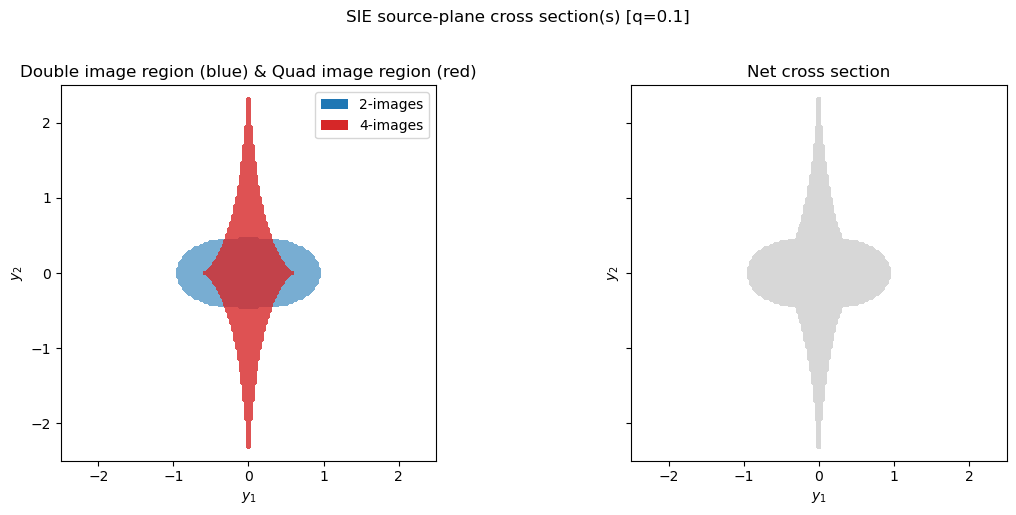

q = 0.1
2-image cross section = 1.4671
4-image cross section = 1.6793
Sum (2+4) cross section = 3.1464
Net cross section = 2.3611


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

# --------------------------------------------------------
# (A) 2-image (double) and 4-image (quad) regions together
# --------------------------------------------------------
axes[0].contourf(y1, y2, m2, levels=[0.5,1], colors=['tab:blue'], alpha=0.6)
axes[0].contourf(y1, y2, m4, levels=[0.5,1], colors=['tab:red'], alpha=0.8)

axes[0].set_title("Double image region (blue) & Quad image region (red)")
axes[0].set_xlabel(r"$y_1$")
axes[0].set_ylabel(r"$y_2$")
axes[0].set_aspect('equal', adjustable='box')

legend_elements = [
    Patch(facecolor='tab:blue', label='2-images'),
    Patch(facecolor='tab:red', label='4-images')
]
axes[0].legend(handles=legend_elements, loc='upper right')

# --------------------------------------------------
# (B) Net image region
# --------------------------------------------------
axes[1].contourf(y1, y2, mnet, levels=[0.5,1], colors=['lightgray'], alpha=0.9)
axes[1].set_title("Net cross section")
axes[1].set_xlabel(r"$y_1$")
axes[1].set_ylabel(r"$y_2$")
axes[1].set_aspect('equal', adjustable='box')

plt.suptitle(fr"SIE source-plane cross section(s) [q={q}]", y=1.02)
plt.tight_layout()
plt.show()

print(f"q = {q}")
print(f"2-image cross section = {sigma_2:.4f}")
print(f"4-image cross section = {sigma_4:.4f}")
print(f"Sum (2+4) cross section = {sigma_2 + sigma_4:.4f}")
print(f"Net cross section = {sigma_net:.4f}")


100%|██████████| 30/30 [04:22<00:00,  8.74s/it]


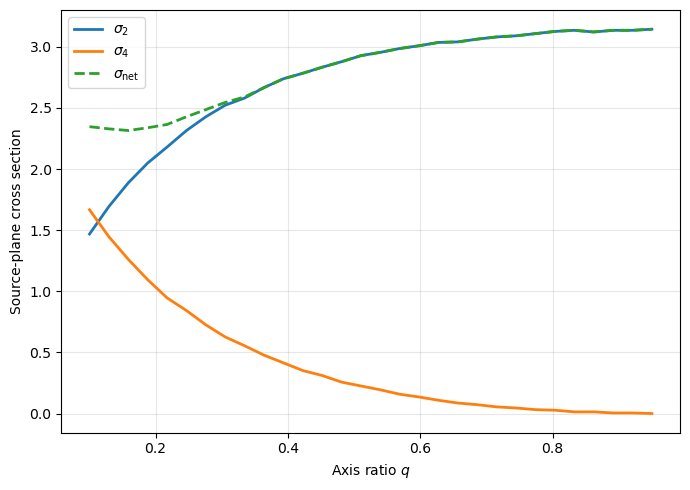

In [11]:
# ==================================================
# SWEEPING OVER q
# ==================================================
from tqdm import tqdm
q_vals = np.linspace(0.1, 0.95, 30)
sig2, sig4, sigt = [], [], []

for q in tqdm(q_vals):
    s2, s4, sm, *_ = cross_sections_for_q(q, Ny=150)
    sig2.append(s2)
    sig4.append(s4)
    sigt.append(sm)

plt.figure(figsize=(7,5))
plt.plot(q_vals, sig2, label=r"$\sigma_2$", lw=2)
plt.plot(q_vals, sig4, label=r"$\sigma_4$", lw=2)
plt.plot(q_vals, sigt, '--', label=r"$\sigma_{\rm net}$", lw=2)

plt.xlabel(r"Axis ratio $q$")
plt.ylabel("Source-plane cross section")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### SIE cross section normalised to SIS
$\sigma_{SIE} = f(q) * \sigma_{SIS}$

where f(q) is plotted below.

SIS (q~1) cross sections:
SIS 2-image cross section = 3.1464
SIS 4-image cross section = 0.0000
SIS net cross section = 3.1464


100%|██████████| 40/40 [05:04<00:00,  7.61s/it]


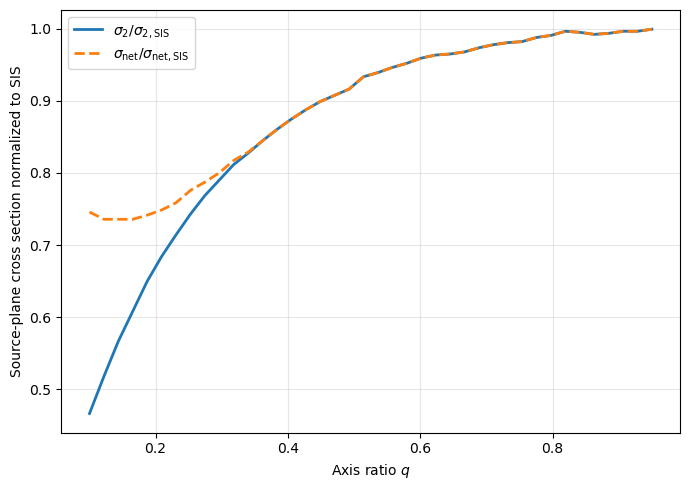

In [16]:
## q ~ 1 (for SIS)
sigma_2_sis, sigma_4_sis, sigma_net_sis, *_ = cross_sections_for_q(0.999, Ny=200)
print(f"SIS (q~1) cross sections:")
print(f"SIS 2-image cross section = {sigma_2_sis:.4f}")
print(f"SIS 4-image cross section = {sigma_4_sis:.4f}")
print(f"SIS net cross section = {sigma_net_sis:.4f}")

## Dimensionless ratio of cross sections
q_vals = np.linspace(0.1, 0.95, 40)
sig2, sig4, sigt = [], [], []

for q in tqdm(q_vals):
    s2, s4, sm, *_ = cross_sections_for_q(q, Ny=150)
    s2/= sigma_2_sis
    sm/= sigma_net_sis
    sig2.append(s2)
    sigt.append(sm)

plt.figure(figsize=(7,5))
plt.plot(q_vals, sig2, label=r"$\sigma_2/\sigma_{2,\rm SIS}$", lw=2)
plt.plot(q_vals, sigt, '--', label=r"$\sigma_{\rm net}/\sigma_{\rm net,SIS}$", lw=2)

plt.xlabel(r"Axis ratio $q$")
plt.ylabel("Source-plane cross section normalized to SIS")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()